# Traveling Salesman Problem

Solved using Pyomo

In [1]:
# import necessary packages
import time
import numpy as np
import numpy.random as random

import dimod
import networkx as nx

from pyomo.environ import *
from pyomo.opt import SolverFactory

{(0, 1): Text(0.9890738129724326, 0.10395586275007898, '1'),
 (0, 2): Text(0.9567727148962293, 0.20336833370730606, '1'),
 (0, 3): Text(0.9045085013861374, 0.2938926345502625, '2'),
 (0, 4): Text(0.8345652820323256, 0.37157244738126716, '5'),
 (0, 5): Text(0.7499999853471915, 0.43301273634077003, '7'),
 (0, 6): Text(0.6545084867333288, 0.47552828238198497, '6'),
 (0, 7): Text(0.552264210281507, 0.49726097031052974, '7'),
 (0, 8): Text(0.44773574600842025, 0.49726097031052974, '7'),
 (0, 9): Text(0.34549148445775957, 0.4755282525796626, '6'),
 (0, 10): Text(0.24999997094273574, 0.43301270653844764, '3'),
 (0, 11): Text(0.16543465935644047, 0.37157238777662244, '8'),
 (0, 12): Text(0.09549149960727343, 0.2938926345502625, '5'),
 (0, 13): Text(0.043227256294859184, 0.20336830390498373, '4'),
 (0, 14): Text(0.010926188020978167, 0.10395581804659546, '7'),
 (0, 15): Text(9.93410742555767e-10, -3.086318824106381e-08, '5'),
 (0, 16): Text(0.010926217823300555, -0.10395588175716253, '2'),
 (0,

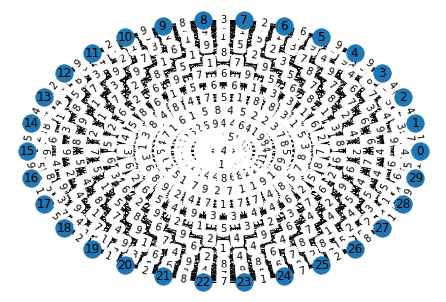

In [2]:
# generate random graph
# number of nodes
num_nodes = 30
# edge generation probability
p = 1
# seed (optional)
seed = 50
random.seed(seed)
#generate graph
graph = nx.gnp_random_graph(num_nodes,p,seed)

for (u, v) in graph.edges():
    graph.edges[u,v]['weight'] = random.randint(1,10)
    
    
# draw graph
pos = nx.circular_layout(graph)
nx.draw(graph, pos=pos, with_labels=True)
labels = nx.get_edge_attributes(graph, 'weight')
nx.draw_networkx_edge_labels(graph, pos=pos, edge_labels=labels)

## Build problem model

In [3]:
# instantiate
model = ConcreteModel()

# define variables ----------------------------------
# binary variables
model.x = VarList(domain=Binary, bounds=(0,1))
# dictionary to assign node/color pairing to certain variable
var_dict = {}
indx = 1
for i,j in graph.edges:
    model.x.add()
    var_dict[(i,j)] = model.x[indx]
    indx += 1
    model.x.add()
    var_dict[(j,i)] = model.x[indx]
    indx += 1

# dummy variables for one-tour constraint
model.u = Var([i for i in range(1,num_nodes+1)], domain=Integers, bounds=(1,num_nodes-1))

# set objective --------------------------------
obj = 0
for i,j in graph.edges:
    obj += graph[i][j]['weight']*var_dict[(i,j)] + graph[j][i]['weight']*var_dict[(j,i)]
model.OBJ = Objective(expr = obj, sense=minimize)

# add constraints --------------------------------
# one incoming path per node
model.one_inc = ConstraintList()
for j in graph.nodes:
    edge_sum = 0
    for i in graph.nodes:
        if (i,j) in graph.edges:
            edge_sum += var_dict[(i,j)]
    model.one_inc.add(edge_sum == 1)
    
# one outgoing path per node
model.one_out = ConstraintList()
for i in graph.nodes:
    edge_sum = 0
    for j in graph.nodes:
        if (i,j) in graph.edges:
            edge_sum += var_dict[(i,j)]
    model.one_out.add(expr = edge_sum == 1)
    
# one tour
model.one_tour = ConstraintList()
for i,j in graph.edges:
    if (i,j)>(1,1) and i<num_nodes and j<num_nodes:
        model.one_tour.add(expr = model.u[i]-model.u[j]+(num_nodes-1)*var_dict[(i,j)] <= num_nodes-2)
        model.one_tour.add(expr = model.u[j]-model.u[i]+(num_nodes-1)*var_dict[(j,i)] <= num_nodes-2)
        
model.pprint()

5 Set Declarations
    one_inc_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :   30 : {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30}
    one_out_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :   30 : {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30}
    one_tour_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :  812 : {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 

        320 :  -Inf :  u[14] - u[7] + 29*x[378] :  28.0 :   True
        321 :  -Inf :  u[7] - u[15] + 29*x[379] :  28.0 :   True
        322 :  -Inf :  u[15] - u[7] + 29*x[380] :  28.0 :   True
        323 :  -Inf :  u[7] - u[16] + 29*x[381] :  28.0 :   True
        324 :  -Inf :  u[16] - u[7] + 29*x[382] :  28.0 :   True
        325 :  -Inf :  u[7] - u[17] + 29*x[383] :  28.0 :   True
        326 :  -Inf :  u[17] - u[7] + 29*x[384] :  28.0 :   True
        327 :  -Inf :  u[7] - u[18] + 29*x[385] :  28.0 :   True
        328 :  -Inf :  u[18] - u[7] + 29*x[386] :  28.0 :   True
        329 :  -Inf :  u[7] - u[19] + 29*x[387] :  28.0 :   True
        330 :  -Inf :  u[19] - u[7] + 29*x[388] :  28.0 :   True
        331 :  -Inf :  u[7] - u[20] + 29*x[389] :  28.0 :   True
        332 :  -Inf :  u[20] - u[7] + 29*x[390] :  28.0 :   True
        333 :  -Inf :  u[7] - u[21] + 29*x[391] :  28.0 :   True
        334 :  -Inf :  u[21] - u[7] + 29*x[392] :  28.0 :   True
        335 :  -Inf :  u[

## Solve

In [ ]:
instance = model.create_instance()
opt = SolverFactory('glpk')

results = opt.solve(model)
results.write()

In [ ]:
model.OBJ.display()

In [ ]:
for (i,j) in var_dict:
    if (i,j) in graph.edges:
        graph[i][j]['color'] = 'blue'
    if var_dict[(i,j)].value > 0.5 or var_dict[(j,i)].value > 0.5:
        graph[i][j]['color'] = 'red'
        
edges = graph.edges()
colors = [graph[u][v]['color'] for u,v in edges]
weights = [graph[u][v]['weight'] for u,v in edges]

# draw
nx.draw(graph, pos, edges=edges, edge_color=colors, with_labels=True)
labels = nx.get_edge_attributes(graph, 'weight')
nx.draw_networkx_edge_labels(graph, pos=pos, edge_labels=labels)